In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

from depth_h5py_gen import *

%load_ext autoreload
%autoreload 2

celeba_root = "F:/datasets/celeba-hq-256/celeba_hq_256/"
depth_data_root = "E:/experiments/stereo/e134-celeba-dataset/"
celeba_train = f"{depth_data_root}/celeba-hq-256_disparity.hdf5"
u8_hdf5_file_path = f"{depth_data_root}/celeba-hq-256_disparity_u8.hdf5"
hdf5_file_path = celeba_train


In [2]:
create_hdf5_from_directory(celeba_root, hdf5_file_path)

Processing . with 30000 files.


Depth gen:   0%|          | 0/30000 [00:00<?, ?item/s]

.:   0%|          | 0/30000 [00:00<?, ?it/s]

Refreshing depth estimator
Lazy loading Depth-Anything-V2


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


DepthAnything-V2 parameters: 335.32M
Refreshing depth estimator
Lazy loading Depth-Anything-V2
DepthAnything-V2 parameters: 335.32M
Refreshing depth estimator
Lazy loading Depth-Anything-V2
DepthAnything-V2 parameters: 335.32M
Refreshing depth estimator
Lazy loading Depth-Anything-V2
DepthAnything-V2 parameters: 335.32M
Refreshing depth estimator
Lazy loading Depth-Anything-V2
DepthAnything-V2 parameters: 335.32M
Refreshing depth estimator
Lazy loading Depth-Anything-V2
DepthAnything-V2 parameters: 335.32M
Skipped 0 files in ..


Accessing depth map at '/25999' in E:/experiments/stereo/e134-celeba-dataset//celeba-hq-256_disparity.hdf5...
41.22066 357.0915
Accessed and reconstructed depth map at '/25999' with shape (256, 256)


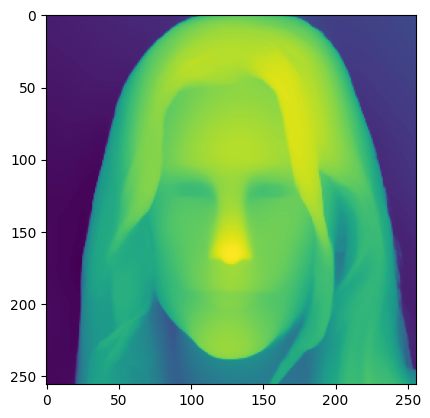

41.22066 357.0915


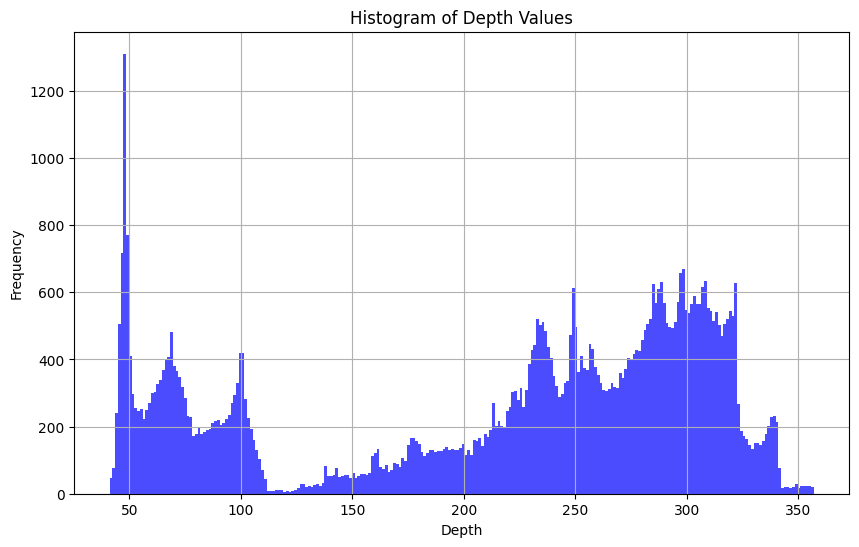

In [7]:
# Open the HDF5 file
#hdf5_file = h5py.File(hdf5_file_path, 'r')

# List all groups and datasets
#print("Listing all groups and datasets:")
#list_all_groups_and_datasets(hdf5_file)
#hdf5_file.close()


# Access a specific depth map
depth_map_path = "/25999"
depth_map = access_depth_map(hdf5_file_path, depth_map_path)
plt.imshow(depth_map)
plt.show()
hist_plot(depth_map)




# patch a file like 'data_large/s/skyscraper/00000064' or '/data_large/t/topiary_garden/00001667'


In [ ]:
'''
file_to_patch = "data_large/t/topiary_garden/00001667"

depth_anything = refresh_depth_estimator()
img = cv2.imread(f"F:/datasets/places/train_large_places365standard/{file_to_patch}.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
depth_map = depth_anything.get_rawdepth(img)

depth_map_path = f'{file_to_patch}'
update_dataset_in_hdf5(hdf5_file_path, depth_map_path, depth_map)
'''

Refreshing depth estimator
Lazy loading Depth-Anything-V2
DepthAnything-V2 parameters: 335.32M
Updated dataset 'data_large/t/topiary_garden/00001667' successfully.


# Assess u8 error

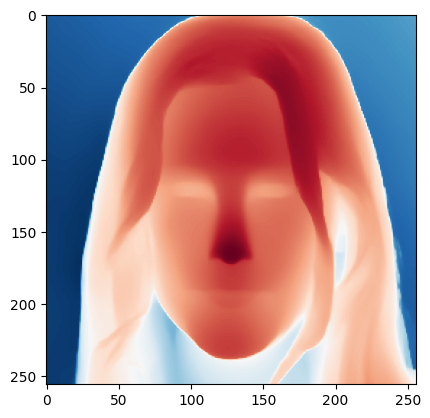

41.22066 357.0915


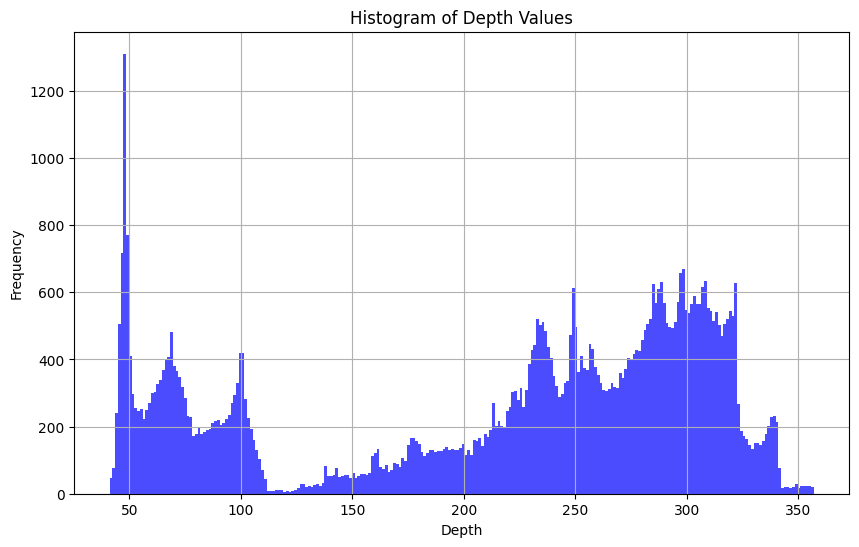

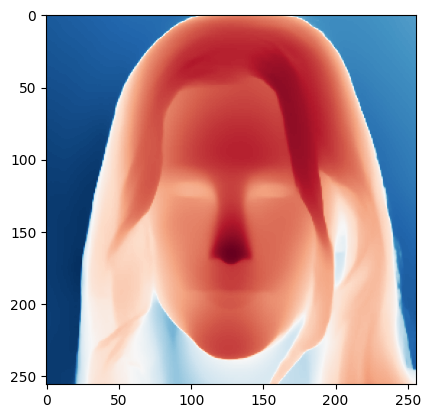

0 255


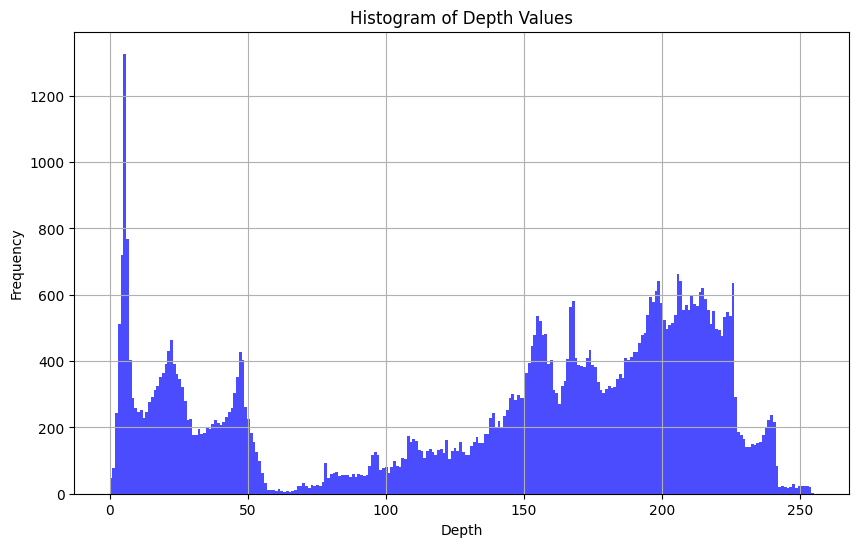

0 255


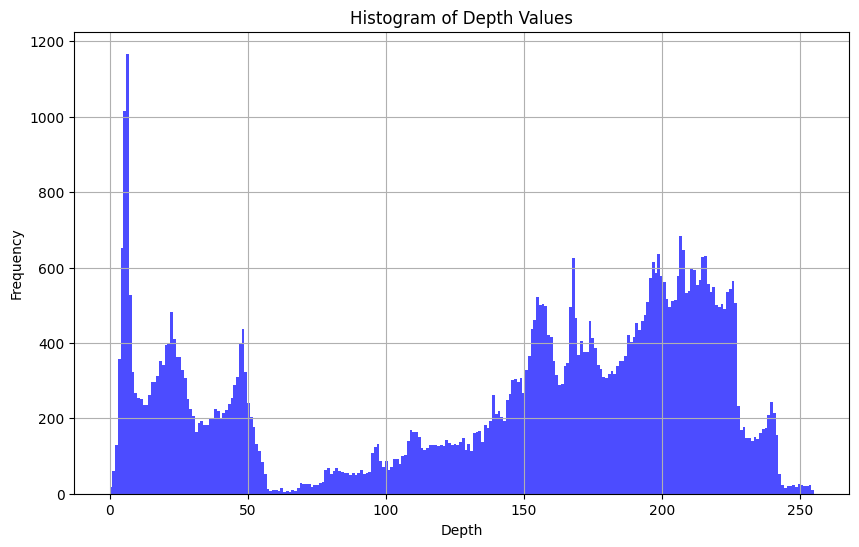

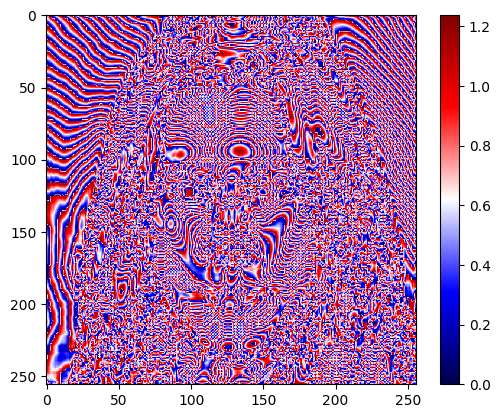

0.0 1.2387085


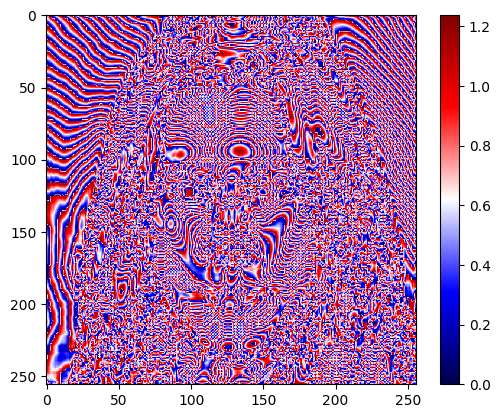

0.0 1.2387085


In [9]:
depth_map_reconstructed = depth_map.copy()
reconstructed_min = np.min(depth_map)
reconstructed_range = np.max(depth_map) - reconstructed_min
depth_map_u8_rounded = np.round((depth_map_reconstructed - reconstructed_min) / reconstructed_range * 255)
depth_map_u8_rounded = depth_map_u8_rounded.astype(np.uint8)

depth_map_u8 = (depth_map-np.min(depth_map))/(np.max(depth_map)-np.min(depth_map))*255
depth_map_u8 = depth_map_u8.astype(np.uint8)

#color map good for depth
plt.imshow(depth_map, cmap='RdBu_r')
plt.show()
hist_plot(depth_map)
plt.imshow(depth_map_u8, cmap='RdBu_r')
plt.show()
hist_plot(depth_map_u8)
hist_plot(depth_map_u8_rounded)


depth_map_u8_back_to_float = depth_map_u8.astype(np.float32)/255
depth_map_u8_back_to_float = depth_map_u8_back_to_float*(reconstructed_range)+reconstructed_min

diff_error = depth_map-depth_map_u8_back_to_float

# my error is between 0 and 1 use a colormap that is centered around 0 and draw the colormap legend on the side
plt.imshow(diff_error, cmap='seismic')
plt.colorbar()
plt.show()
print(np.min(diff_error), np.max(diff_error))

depth_map_u8_rounded_back_to_float = depth_map_u8_rounded.astype(np.float32)/255
depth_map_u8_rounded_back_to_float = depth_map_u8_rounded_back_to_float*(reconstructed_range)+reconstructed_min
diff_error_rounded = depth_map-depth_map_u8_back_to_float
plt.imshow(diff_error_rounded, cmap='seismic')
plt.colorbar()
plt.show()
print(np.min(diff_error_rounded), np.max(diff_error_rounded))


# create new u8 hdf5

In [10]:
# open the hdf5 and create a new hdf5 file in u8 format
# copy the data from the old hdf5 to the new hdf5
copy_hdf5_to_u8(hdf5_file_path, u8_hdf5_file_path)

Copying groups/datasets:   0%|          | 0/30000 [00:00<?, ?item/s]

# extract depth for poster inference

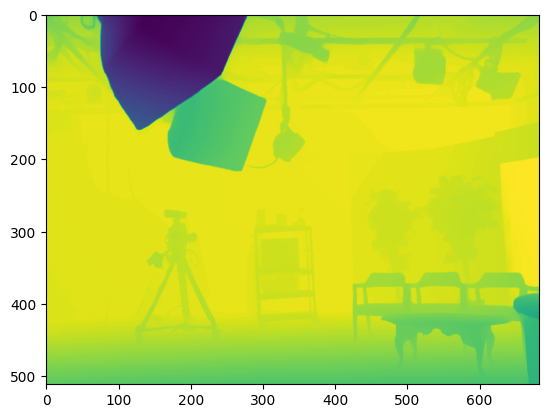

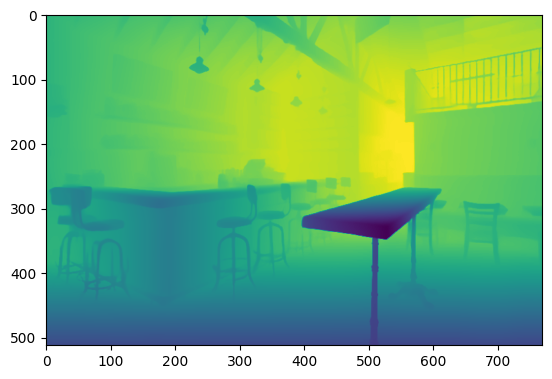

In [5]:
hdf5_file = "C:/experiments/places_dataset/train_large_places365standard_disparity_u8.hdf5"

def normalize_depth(disparity_map):
    disparityf = disparity_map.astype(np.float32)
    disparity_not_zero = disparityf > 0.0
    disparity_zero = disparityf == 0.0
    true_depth = np.zeros(disparityf.shape)
    A = 1.0
    B = 0.0005
    max_depth = 1.0
    true_depth[disparity_not_zero] = 1/(A+B*disparityf[disparity_not_zero])
    true_depth[disparity_zero] = max_depth

    min_depth,max_depth = true_depth.min(), true_depth.max()
    true_depth_normalized = (true_depth - min_depth) / (max_depth - min_depth)
    return true_depth_normalized


def load_depth_from_hdf5(hdf5_path, depth_path, return_orig=False):
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        # Access the dataset
        dataset = hdf5_file[depth_path]
        depth_map_u16 = dataset[:]
        
        # Retrieve mean and std attributes
        if 'min' in dataset.attrs:
            depth_map_min = dataset.attrs['min']
        else:
            print(f"Attribute 'min' not found in dataset {depth_path}")
            depth_map_min = 4.1578239029840205 # average min of the dataset
                
        if 'range' in dataset.attrs:
            depth_map_range = dataset.attrs['range']
        else:
            print(f"Attribute 'range' not found in dataset {depth_path}")
            depth_map_range = 519.2757145688164 # average range of the dataset
        
        # Convert uint16 back to normalized float
        divisor = 65535.0 if depth_map_u16.dtype == np.uint16 else 255.0 
        depth_map_normalized = depth_map_u16.astype(np.float32) / divisor
        
        # Denormalize to reconstruct the original depth map
        depth = depth_map_normalized * depth_map_range + depth_map_min
        
        #out_depth = depth / np.max(depth)
        out_depth = normalize_depth(depth)

        out_depth = out_depth.astype(np.float32)
        if return_orig:
            return out_depth, depth
        else:
            return out_depth
        
depth_map1 = load_depth_from_hdf5(hdf5_file, 'data_large/t/television_studio/00000056')
depth_map2 = load_depth_from_hdf5(hdf5_file, 'data_large/b/bar/00000016')

plt.imshow(depth_map1)
plt.show()

plt.imshow(depth_map2)
plt.show()

np.save("C:/experiments/places_dataset/00000056.npy", depth_map1)
np.save("C:/experiments/places_dataset/00000016.npy", depth_map2)